In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/insitu_uavsar_v2.parq')
snotel = df[df.datasource == 'NRCS']

wx = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/snotel.parq')

In [26]:
snotel

,site_name,end_datetime,SWE,datasource,SD,temp,lon,lat,elev,SWE-A,...,dTime,VV_cor,UV_int_VV_sd,UV_int_VH_sd,UV_int_HV_sd,UV_int_HH_sd,UV_unw_VV_sd,UV_unw_VH_sd,UV_unw_HV_sd,UV_unw_HH_sd
0,mores,2021-01-20,0.42164,NRCS,1.4224,-3.4,-115.66588,43.93200,6100.0,NaN,...,5 days,0.580790,0.003897,0.001110,-0.000004,0.007874,0.002975,-0.001686,0.000327,0.004594
1,banner,2021-01-20,0.32512,NRCS,1.2446,-8.5,-115.23447,44.30342,7040.0,NaN,...,5 days,0.711911,-0.033724,-0.036493,-0.037516,-0.033259,-0.029351,-0.030420,-0.031111,-0.027262
2,bogus,2021-01-20,0.36830,NRCS,1.1938,-2.3,-116.09685,43.76377,6340.0,NaN,...,5 days,0.684516,0.051787,0.049622,0.050281,0.049621,0.056621,0.056420,0.056701,0.054078
0,bogus,2021-03-22,0.62738,NRCS,1.6256,-1.9,-116.09685,43.76377,6340.0,NaN,...,6 days,0.339429,-0.041862,-0.052217,-0.046439,-0.039298,NaN,NaN,NaN,NaN
1,banner,2021-03-22,0.54864,NRCS,1.5494,-3.7,-115.23447,44.30342,7040.0,NaN,...,6 days,0.303675,-0.003572,0.002151,0.005794,0.005945,NaN,NaN,NaN,NaN
2,mores,2021-03-22,0.70358,NRCS,1.7526,-1.6,-115.66588,43.93200,6100.0,NaN,...,6 days,0.336880,0.002688,-0.001092,-0.002444,-0.005803,0.020568,0.018044,0.022131,NaN
0,bogus,2021-03-22,0.62738,NRCS,1.6256,-1.9,-116.09685,43.76377,6340.0,NaN,...,6 days,0.372109,0.014471,0.012125,0.014104,0.019997,0.025934,0.039678,NaN,0.027480
1,banner,2021-03-22,0.54864,NRCS,1.5494,-3.7,-115.23447,44.30342,7040.0,NaN,...,6 days,0.375524,-0.026479,-0.015924,-0.018459,-0.020303,NaN,-0.030887,-0.007826,NaN
2,mores,2021-03-22,0.70358,NRCS,1.7526,-1.6,-115.66588,43.93200,6100.0,NaN,...,6 days,0.371855,-0.014513,-0.012051,-0.015955,-0.006976,-0.036649,-0.029789,-0.011046,NaN
0,mores,2021-03-03,0.67056,NRCS,2.1590,2.0,-115.66588,43.93200,6100.0,NaN,...,21 days,0.363011,0.333785,0.337672,0.340519,0.332645,NaN,NaN,NaN,NaN


In [24]:
for site_name, df in wx.groupby('site_name'):
    
    uavsar_data = snotel[snotel.site_name == site_name]

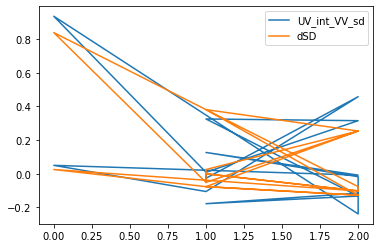

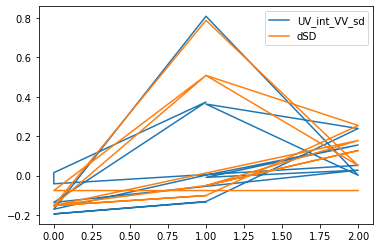

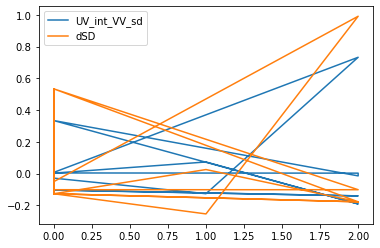

In [12]:
for i, df in snotel.groupby('site_name'):
    df[['UV_int_VV_sd', 'dSD']].plot(linestyle = None)
    plt.show()

In [13]:
df

,site_name,end_datetime,SWE,datasource,SD,temp,lon,lat,elev,SWE-A,...,dTime,VV_cor,UV_int_VV_sd,UV_int_VH_sd,UV_int_HV_sd,UV_int_HH_sd,UV_unw_VV_sd,UV_unw_VH_sd,UV_unw_HV_sd,UV_unw_HH_sd
0,mores,2021-01-20,0.42164,NRCS,1.4224,-3.4,-115.66588,43.932,6100.0,NaN,...,5 days,0.580790,0.003897,0.001110,-0.000004,0.007874,0.002975,-0.001686,0.000327,0.004594
2,mores,2021-03-22,0.70358,NRCS,1.7526,-1.6,-115.66588,43.932,6100.0,NaN,...,6 days,0.336880,0.002688,-0.001092,-0.002444,-0.005803,0.020568,0.018044,0.022131,NaN
2,mores,2021-03-22,0.70358,NRCS,1.7526,-1.6,-115.66588,43.932,6100.0,NaN,...,6 days,0.371855,-0.014513,-0.012051,-0.015955,-0.006976,-0.036649,-0.029789,-0.011046,NaN
0,mores,2021-03-03,0.67056,NRCS,2.1590,2.0,-115.66588,43.932,6100.0,NaN,...,21 days,0.363011,0.333785,0.337672,0.340519,0.332645,NaN,NaN,NaN,NaN
2,mores,2021-03-10,0.68326,NRCS,1.9812,-3.3,-115.66588,43.932,6100.0,NaN,...,7 days,0.567882,-0.191361,-0.190513,-0.193813,-0.188792,-0.188277,-0.189960,-0.191786,-0.186553
1,mores,2020-02-13,0.54610,NRCS,1.7526,-1.9,-115.66588,43.932,6100.0,NaN,...,13 days,0.333511,0.073030,0.054869,0.059838,0.067428,NaN,NaN,NaN,NaN
0,mores,2021-02-10,0.49784,NRCS,1.6256,-4.6,-115.66588,43.932,6100.0,NaN,...,7 days,0.574957,0.002835,0.006307,0.007927,-0.005402,-0.024578,-0.024304,-0.022829,-0.022489
0,mores,2020-02-21,0.57912,NRCS,1.9050,-2.0,-115.66588,43.932,6100.0,NaN,...,8 days,0.425867,0.138962,0.135401,0.143843,0.142331,0.154003,0.183586,0.152382,0.152276
0,mores,2021-02-10,0.49784,NRCS,1.6256,-4.6,-115.66588,43.932,6100.0,NaN,...,7 days,0.462306,-0.028765,-0.031859,-0.031203,-0.028169,-0.029134,-0.034821,-0.032255,-0.033635
1,mores,2020-03-11,0.60706,NRCS,1.6510,2.3,-115.66588,43.932,6100.0,NaN,...,19 days,0.381776,-0.126741,-0.135704,-0.129852,-0.126770,-0.108354,NaN,-0.108203,-0.103379
